In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from alpha_vantage.timeseries import TimeSeries
import seaborn as sns

from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Get the API key
API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")


In [2]:
# Cell 2: Fetch Data from Alpha Vantage

symbol = "AAPL"
ts = TimeSeries(key=API_KEY, output_format='pandas')
data, _ = ts.get_daily(symbol=symbol, outputsize='full')
data = data.sort_index()
data = data.rename(columns={
    '1. open': 'open',
    '2. high': 'high',
    '3. low': 'low',
    '4. close': 'close',
    '5. volume': 'volume'
})



In [3]:
# Cell 3: Feature Engineering
data['return'] = data['close'].pct_change()
data['rsi'] = RSIIndicator(data['close'], window=14).rsi()
macd = MACD(data['close'])
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()

# Forward return as signal (next day up/down)
data['target'] = np.where(data['return'].shift(-1) > 0, 1, 0)

# Drop NaNs
data = data.dropna()



In [4]:
# En el notebook de entrenamiento
data.to_csv('/workspaces/backtesting/investment-portfolio-project/data/data_features.csv', index=False)


In [5]:
 #Cell 4: Train-Test Split
features = ['rsi', 'macd', 'macd_signal']
X = data[features]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)



In [6]:
# Cell 5: Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)




,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# Cell 6: Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))



              precision    recall  f1-score   support

           0       0.47      0.45      0.46       602
           1       0.53      0.55      0.54       680

    accuracy                           0.50      1282
   macro avg       0.50      0.50      0.50      1282
weighted avg       0.50      0.50      0.50      1282

ROC AUC Score: 0.5019017490717217


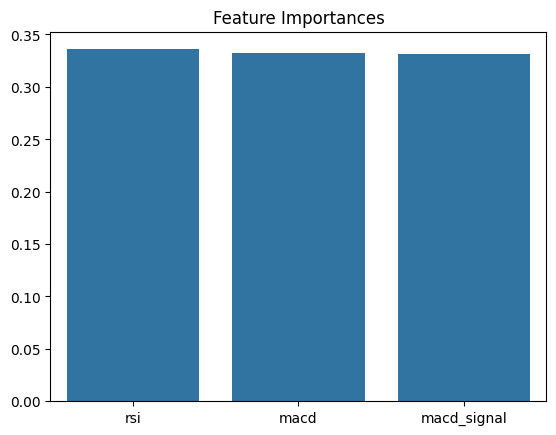

In [8]:
# Cell 7: Plot feature importance
importances = model.feature_importances_
sns.barplot(x=features, y=importances)
plt.title("Feature Importances")
plt.show()

In [6]:
# Crear DataFrame para backtesting
# Usamos 'data' como el DataFrame con los precios originales
# y X_test.index como las fechas de las predicciones

# Extraer precios de cierre
close_prices = data.loc[X_test.index, 'close']

# Crear DataFrame con señales y precios
signal_df = pd.DataFrame({
    'close': close_prices,
    'y_pred': y_pred
})
signal_df.index = pd.to_datetime(signal_df.index)
signal_df = signal_df[['close', 'y_pred']]  # Ordenar columnas

# Guardar CSV para usar en el siguiente notebook
output_path = "/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv"
signal_df.to_csv(output_path)

print(f"✅ Archivo guardado en: {output_path}")
signal_df.head()


NameError: name 'y_pred' is not defined

In [10]:
import joblib

# Save the trained RandomForest model
joblib.dump(model, '/workspaces/backtesting/investment-portfolio-project/models/random_forest_model.pkl')


['/workspaces/backtesting/investment-portfolio-project/models/random_forest_model.pkl']

In [11]:
# En el notebook de entrenamiento
X.to_csv('/workspaces/backtesting/investment-portfolio-project/data/X_train.csv', index=False)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score


# 1. Definimos hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 2. Instanciamos el clasificador base
rf = model

# 3. Creamos el GridSearch
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='roc_auc',
                           verbose=2,
                           n_jobs=-1)

# 4. Entrenamos
grid_search.fit(X_train, y_train)

# 5. Mostramos la mejor combinación
print("🧠 Best Parameters:")
print(grid_search.best_params_)

# 6. Usamos el mejor modelo
best_model = grid_search.best_estimator_

# 7. Evaluamos
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n📈 Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_best):.4f}")



Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=1, 

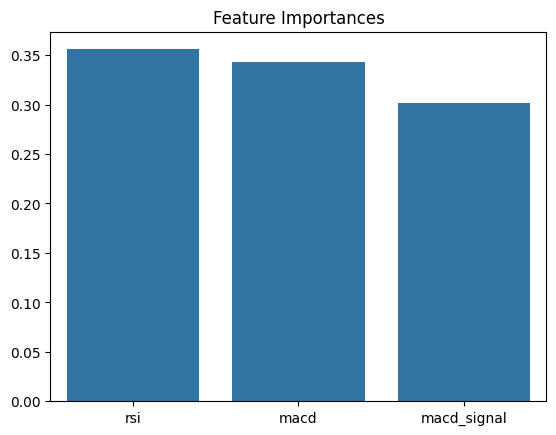

In [13]:
# Cell 7: Plot feature importance
importances = best_model.feature_importances_
sns.barplot(x=features, y=importances)
plt.title("Feature Importances")
plt.show()

In [14]:
# Crear DataFrame para backtesting
# Usamos 'data' como el DataFrame con los precios originales
# y X_test.index como las fechas de las predicciones





signal_df['y_pred_best'] = y_pred_best
signal_df.to_csv('/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv')
print(f"✅ Archivo guardado en: {output_path}")
signal_df.head()


✅ Archivo guardado en: /workspaces/backtesting/investment-portfolio-project/data/signal_data.csv


,close,y_pred,y_pred_best
date,,,
2020-05-04,293.16,0,1
2020-05-05,297.56,1,1
2020-05-06,300.63,0,1
2020-05-07,303.74,0,1
2020-05-08,310.13,0,1


In [15]:
import joblib

# Save the trained RandomForest model
joblib.dump(best_model, '/workspaces/backtesting/investment-portfolio-project/models/best_model_grid.pkl')


['/workspaces/backtesting/investment-portfolio-project/models/best_model_grid.pkl']

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Inicializar el modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predecir y evaluar
xgb_predictions = xgb_model.predict(X_test)

y_proba_best_xgb = xgb_model.predict_proba(X_test)[:, 1]


print(f"ROC AUC: {roc_auc_score(y_test, y_proba_best_xgb):.4f}")
print("XGBoost Accuracy:", roc_auc_score(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions))

# Guardar el modelo
joblib.dump(best_model, '/workspaces/backtesting/investment-portfolio-project/models/xgboost_model.pkl')



ROC AUC: 0.4860
XGBoost Accuracy: 0.5036105139730311
              precision    recall  f1-score   support

           0       0.47      0.42      0.45       602
           1       0.53      0.59      0.56       680

    accuracy                           0.51      1282
   macro avg       0.50      0.50      0.50      1282
weighted avg       0.51      0.51      0.51      1282



/workspaces/backtesting/my_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:50:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['/workspaces/backtesting/investment-portfolio-project/models/xgboost_model.pkl']

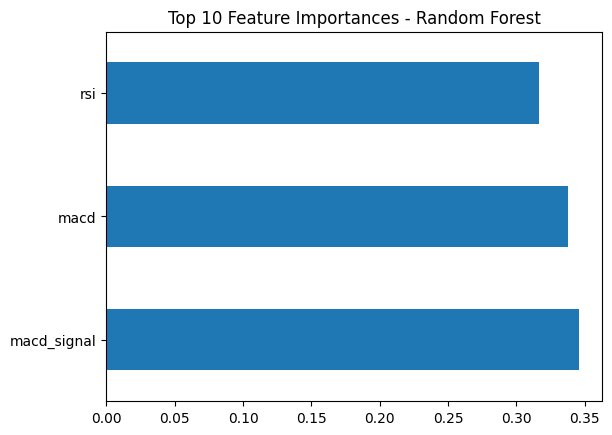

In [17]:
# Visualización de importancia de características para Random Forest
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()




In [18]:


signal_df['y_pred_xgb'] = xgb_predictions
signal_df.to_csv('/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv')


In [9]:
import pandas as pd

# Paths
feature_path = '/workspaces/backtesting/investment-portfolio-project/data/data_features.csv'
signal_path = '/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv'

# 1. Cargar ambos archivos
feature_df = pd.read_csv(feature_path)
signal_df = pd.read_csv(signal_path, parse_dates=['date'])

# 2. Ajustar tamaños si son diferentes
min_len = min(len(feature_df), len(signal_df))
feature_df = feature_df.iloc[-min_len:].reset_index(drop=True)
dates = signal_df['date'].iloc[-min_len:].reset_index(drop=True)

# 3. Insertar columna de fechas
feature_df.insert(0, 'date', dates)

# 4. Guardar nuevo archivo con columna date
feature_df.to_csv(feature_path, index=False)

print(f"✅ Columna 'date' añadida y archivo sobrescrito en:\n{feature_path}")
feature_df.head()


ValueError: cannot insert date, already exists

In [10]:
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Cargar los datos
feature_data = pd.read_csv('/workspaces/backtesting/investment-portfolio-project/data/data_features.csv', parse_dates=['date'])
signal_data = pd.read_csv('/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv', parse_dates=['date'])

# Usar 'date' como índice en ambos
feature_data.set_index('date', inplace=True)
signal_data.set_index('date', inplace=True)

# Calcular señales clásicas
feature_data['SMA_10'] = feature_data['close'].rolling(window=10).mean()
feature_data['SMA_50'] = feature_data['close'].rolling(window=50).mean()
feature_data['y_pred_crossover'] = np.where(feature_data['SMA_10'] > feature_data['SMA_50'], 1, 0)

feature_data['y_pred_rsi'] = np.where(feature_data['rsi'] < 30, 1, 0)
feature_data['y_pred_rsi'] = np.where(feature_data['rsi'] > 70, 0, feature_data['y_pred_rsi'])

signal_data = signal_data.drop(columns=['y_pred_crossover', 'y_pred_rsi'], errors='ignore')
signal_data = signal_data.join(strategy_signals, how='left')


# Guardar el resultado
output_path = '/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv'
signal_data.to_csv(output_path)

print(f"✅ Señales añadidas correctamente. Archivo actualizado: {output_path}")
signal_data.tail()


✅ Señales añadidas correctamente. Archivo actualizado: /workspaces/backtesting/investment-portfolio-project/data/signal_data.csv


,close,y_pred,y_pred_best,y_pred_xgb,y_pred_crossover,y_pred_rsi
date,,,,,,
2025-06-03,203.27,1,1,1,0,0
2025-06-04,202.82,1,1,1,0,0
2025-06-05,200.63,1,1,1,0,0
2025-06-06,203.92,1,1,1,0,0
2025-06-09,201.45,1,1,1,0,0
